In [1]:
from langchain_openai import ChatOpenAI

model_llm = ChatOpenAI(model="gpt-4o", temperature=0)


# For this tutorial we will use custom tool that returns pre-defined values for weather in two cities (NYC & SF)

from typing import Literal

from langchain_core.tools import tool

In [ ]:
from typing_extensions import TypedDict
from typing import Annotated, Literal , List , Optional , Any
from pydantic import BaseModel, Field , field_validator, ValidationInfo , model_validator
from langgraph.graph.message import AnyMessage , add_messages
from langgraph.graph import StateGraph, MessagesState, START, END
import sys
import os
import requests
from datetime import datetime
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), "../..")))

from api.booking import BookingAPI
from api.geoCoding import GeoCodingAPI
from api.getKey import OAuthClient
from api.getQuotes import QuotesAPI
from api.is_Airport import IsAirport
# from booking_agent.val_globals import pick_up_result , destination_result ,booking_details
jupiterAPI = os.getenv('JUPITER_API')
quoteAPI = str(jupiterAPI) + "/demand/v1/quotes"
bookingsAPI  = str(jupiterAPI) + '/demand/v1/bookings'
# booking_agent\val_globals.py
def getData_for_duckling(text, dims):
    url = 'http://localhost:8000/parse'
    data = {
        'locale': 'en_US',
        'text': text,
        'dims': dims,
        'tz': "Asia/Ho_Chi_Minh"
    }
    response = requests.post(url, data=data)
    if response.status_code == 200:
        json_response = response.json()
        # value = json_response[0]['value']['value']
        return json_response
    else:
        return f"Error: {response.status_code}"
pick_up_result = None
destination_result = None
booking_details = None

class BookingCarDetails(BaseModel):
    """Details for the bookings car details"""
    name: str = Field(
        ...,
        description="The name of the person booking the ride. Do not autofill if not provided",
    )
    number_phone: str = Field(
        ...,
        description="The phone number of the user. Do not autofill if not provided",
    )
    pick_up_location: str = Field(
        ...,
        description="The location where the user will be picked up. This can be a full address or a specific location name. Do not autofill if not provided",
    )
    destination_location: str = Field(
        ...,
        description="The destination location for the ride. This can be a full address or a specific location name. Do not autofill if not provided"
    )
    pick_up_time: str = Field(
        ...,
        description="The time the user intends to be picked up. No format keeps the text related to time. Do not autofill if not provided"
    )
    # flight_code: str = Field(
    #     # default= 'None',
    #     ...,
    #     description="Flight numbers, consisting of letters and numbers, usually start with the airline code (e.g. VN123, SQ318)."
    # )
    # flight : str = Field(..., description="Request or No Request")
    
    @field_validator('pick_up_location')
    @classmethod
    def validate_pickup(cls, value:str, info: ValidationInfo):
        geoCodingAPI = GeoCodingAPI()
        if value == '':
            return ''
        else :
            geoCoding_pickup = geoCodingAPI.get_geocoding(value)
            if geoCoding_pickup["status"] == "OK" :
                return geoCoding_pickup['results'][0]['formatted_address']
            else:
                raise ValueError(f"Invalid pick-up location: {value}")
            
    @field_validator('destination_location')
    @classmethod
    def validate_destination(cls, value : str, info: ValidationInfo):
        geoCodingAPI = GeoCodingAPI()
        if value == '':
            return ''
        else :
            geoCoding_destination = geoCodingAPI.get_geocoding(value)
            if geoCoding_destination["status"] == "OK":
                if geoCoding_destination['results'][0]['formatted_address'] == info.data['pick_up_location']:
                    raise ValueError(f"Invalid destination location: {value}")
                else:

                    return geoCoding_destination['results'][0]['formatted_address']
            else:
            
                raise ValueError(f"Invalid destination location: {value}")
    # @field_validator('pick_up_time')
    # @classmethod
    # def validate_pick_up_time(cls, value : str):
    #     dimensions = ["time"]
    #     if value == '':
    #         return ''
        
    #     try:
    #         expected_format = "%Y-%m-%dT%H:%M:%S.%f%z"
    #         parsed_datetime = datetime.strptime(value, expected_format)
    #         return value
    #     except :
    #         data = getData_for_duckling(value,dimensions)
    #         if data and isinstance(data, list) and 'value' in data[0] and 'value' in data[0]['value']:
    #             return data[0]['value']['value']
    #         else:
    #             raise ValueError("Invalid time format")
         
    
    
    # @model_validator(mode="after")
    # def set_flight_code_if_airport(self)-> str:
    #     global pick_up_result , destination_result ,booking_details
    #     geoCodingAPI = GeoCodingAPI()
    #     API_Airport = IsAirport(base_url=jupiterAPI + '/v2/distance/airport')

    #     if self.pick_up_location:
    #         geoCoding_pickup = geoCodingAPI.get_geocoding(self.pick_up_location)
    #         pick_up_result = geoCoding_pickup
    #         if geoCoding_pickup["status"] == "OK":
    #             pick_up_lat = geoCoding_pickup['results'][0]['geometry']['location']['lat']
    #             pick_up_lng = geoCoding_pickup['results'][0]['geometry']['location']['lng']
                
    #             is_Airport = API_Airport.is_Airport(pick_up_lat, pick_up_lng)
    #             if is_Airport[0] == False:  # Nếu là sân bay
    #                 self.flight = 'No request'
    #                 self.flight_code = 'None'
    #             else :
    #                 self.flight = 'Request'
                    
                    
    #     if self.destination_location:
    #         geoCoding_destination = geoCodingAPI.get_geocoding(self.destination_location)
    #         destination_result = geoCoding_destination
    #     if booking_details is None:
    #         booking_details = self
    #     else:
    #         non_empty_details = {key: value for key, value in self.dict().items() if value not in [None, ""]}
    #         booking_details = booking_details.copy(update=non_empty_details)
        
    #     # print(booking_details)
    #     return self

In [3]:
class Quote:
    def __init__(self, quote_id, expires_at, vehicle_type, price_value, price_currency, luggage, passengers, provider_name, provider_phone):
        self.quote_id = quote_id
        self.expires_at = expires_at
        self.vehicle_type = vehicle_type
        self.price_value = price_value
        self.price_currency = price_currency
        self.luggage = luggage
        self.passengers = passengers
        self.provider_name = provider_name
        self.provider_phone = provider_phone
    def to_dict(self):
        return {
            "quote_id": self.quote_id,
            "expires_at": self.expires_at,
            "vehicle_type": self.vehicle_type,
            "price_value": self.price_value,
            "price_currency": self.price_currency,
            "luggage": self.luggage,
            "passengers": self.passengers,
            "provider_name": self.provider_name,
            "provider_phone": self.provider_phone
        }
    def __repr__(self):
        return (f"Quote(quote_id={self.quote_id}, expires_at={self.expires_at}, vehicle_type={self.vehicle_type}, "
                f"price_value={self.price_value}, price_currency={self.price_currency}, luggage={self.luggage}, "
                f"passengers={self.passengers}, provider_name={self.provider_name}, provider_phone={self.provider_phone})")

In [4]:
@tool 
def check_Airport(pick_up_location: str) :
    """Call the function to check if pick_up_location is an airport"""
    API_Airport = IsAirport(base_url=jupiterAPI + '/v2/distance/airport')
    geoCodingAPI = GeoCodingAPI()
    geoCoding_pickup = geoCodingAPI.get_geocoding(pick_up_location)
    if geoCoding_pickup["status"] == "OK":
        pick_up_lat = geoCoding_pickup['results'][0]['geometry']['location']['lat']
        pick_up_lng = geoCoding_pickup['results'][0]['geometry']['location']['lng']  
        is_Airport = API_Airport.is_Airport(pick_up_lat, pick_up_lng)
    return is_Airport[0]

In [5]:
@tool(response_format="content_and_artifact")
def get_quotes(booking_details : BookingCarDetails):
    """Call function to fetches quotes for car bookings based on the provided booking details."""
    quotesAPI = QuotesAPI(os.getenv("JUPITER_API") + "/demand/v1/quotes")
    geoCodingAPI = GeoCodingAPI()
    # geoCoding_destination =
    geoCoding_pickup =  geoCodingAPI.get_geocoding(booking_details.pick_up_location)
    geoCoding_destination = geoCodingAPI.get_geocoding(booking_details.destination_location)
    # input_datetime = datetime.fromisoformat(pick_up_time)
    pickup_datetime = "2025-03-07T09:24:10.000Z"
    
    pickup_coords = { "latitude": float(geoCoding_pickup['results'][0]['geometry']['location']['lat']),"longitude": float(geoCoding_pickup['results'][0]['geometry']['location']['lng']),}
    destination_coords = { "latitude": float(geoCoding_destination['results'][0]['geometry']['location']['lat']),"longitude": float(geoCoding_destination['results'][0]['geometry']['location']['lng']),}
    quotes_data = quotesAPI.get_quotes(pickup_datetime, pickup_coords, destination_coords)
    quotes = []
    for item in quotes_data:
        quote = Quote(
        quote_id=item['quoteId'],
        expires_at=item['expiresAt'],
        vehicle_type=item['vehicleType'],
        price_value=item['price']['value'],
        price_currency=item['price']['currency'] if 'currency' in item['price'] and item['price']['currency'] is not None else 'CAD',
        luggage=item['luggage'],
        passengers=item['passengers'],
        provider_name=item['provider']['name'],
        provider_phone=item['provider']['phone']
        )
        quotes.append(quote)
    response = []
    for quote in quotes:
        response.append({
            "title": f"{quote.vehicle_type} - {quote.price_value} {quote.price_currency}",
            "payload": f"{quote.quote_id}"
        })
    return {"context": "Please user chooses quote"}, {"quotes": response}

In [6]:
@tool
def accept_booking(quote_Id: str ,booking_details : BookingCarDetails ):
    """Call function to accept booking with quote_ID."""
    bookingAPI = BookingAPI(bookingsAPI)
    # quote_id = tracker.get_slot("quoteId")
    person_name = booking_details.name
    number_contact = booking_details.number_phone
    
    passenger_info = {
        "title": "Mr",
        "phone": number_contact,
        "firstName": person_name,
        "lastName": ""
    }
    response = bookingAPI.create_booking(
        quote_id=quote_Id,
        passenger_info=passenger_info
    )
    return response

In [7]:
tools = [get_quotes,check_Airport,accept_booking]

In [8]:
system_prompt = """
        You are a very powerful assistant. 
        If user express the intention to book a ride please guide the user through a booking process. 
        Start get booking details : name, number phone, pick up location, destination location, pick up time
        Ask one question at a time, even if you don't get all the info. Don't list the questions or greet the user. 
        Explain you're gathering info to help.
        Call "check_Airport" to check pick up location. If it is an airport, ask the user if they want to provide a flight code to facilitate the trip.
        Please ask user confirm booking information
        Call "get_quotes" to get quotes for the booking details
        Call "accept_booking" to accept booking with quote_ID
    """

In [9]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [10]:
from langgraph.prebuilt import create_react_agent

graph = create_react_agent(
    model_llm,
    # response_format=BookingCarDetails,
    tools=tools,
    prompt=system_prompt,
    checkpointer=memory,

)

In [11]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        # if isinstance(message, tuple):
        #     print(message)
        # else:
        message.pretty_print()

In [12]:
try :

SyntaxError: incomplete input (4114620631.py, line 1)

In [ ]:
inputs = {"messages": [("user", "i want to book a car from 271 Nguyen Van Linh Danang to 460 Tran Dai Nghia, Da Nang at 9 tomorrow, my name is Huy and my phone number is 0123456789")]}
config = {"configurable": {"user":"huy","thread_id": "1"}}
response = graph.invoke(inputs, config = config)
response
# print_stream(graph.stream(inputs, stream_mode="values"))

{'messages': [HumanMessage(content='i want to book a car from 271 Nguyen Van Linh Danang to 460 Tran Dai Nghia, Da Nang at 9 tomorrow, my name is Huy and  ', additional_kwargs={}, response_metadata={}, id='098e2157-e285-4f54-8d0e-e7d1dcea16ae'),
  AIMessage(content='I can help you with that. Could you please provide your phone number to complete the booking details?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 609, 'total_tokens': 631, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-9b7cd35c-9d5b-4b91-bcbc-9ca18695f9c7-0', usage_metadata={'input_tokens': 609, 'output_tokens': 22, 'total_tokens': 631, 'input_token_details': {'audio': 0, '

In [14]:
inputs = {"messages": [("user", "+84917181880")]}
response = graph.invoke(inputs, config = config)
response

{'messages': [HumanMessage(content='i want to book a car from 271 Nguyen Van Linh Danang to 460 Tran Dai Nghia, Da Nang at 9 tomorrow, my name is Huy and  ', additional_kwargs={}, response_metadata={}, id='098e2157-e285-4f54-8d0e-e7d1dcea16ae'),
  AIMessage(content='I can help you with that. Could you please provide your phone number to complete the booking details?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 609, 'total_tokens': 631, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-9b7cd35c-9d5b-4b91-bcbc-9ca18695f9c7-0', usage_metadata={'input_tokens': 609, 'output_tokens': 22, 'total_tokens': 631, 'input_token_details': {'audio': 0, '

In [15]:
branch_state = graph.get_state(config, subgraphs=True)

In [ ]:
branch_state

StateSnapshot(values={'messages': [HumanMessage(content='i want to book a car from 271 Nguyen Van Linh Danang to 460 Tran Dai Nghia, Da Nang at 9 tomorrow, my name is Huy and  ', additional_kwargs={}, response_metadata={}, id='098e2157-e285-4f54-8d0e-e7d1dcea16ae'), AIMessage(content='I can help you with that. Could you please provide your phone number to complete the booking details?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 609, 'total_tokens': 631, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-9b7cd35c-9d5b-4b91-bcbc-9ca18695f9c7-0', usage_metadata={'input_tokens': 609, 'output_tokens': 22, 'total_tokens': 631, 'input_token_detai

: 

In [ ]:
inputs = {"messages": [("user", "d0e40cea-d4f2-43bf-b9d8-d16730c89675")]}
response = graph.invoke(inputs, config = config)
response

{'messages': [HumanMessage(content='i want to book a car from 271 Nguyen Van Linh Da nang to 460 Tran Dai Nghia, Da Nang at 9 tomorrow, my name is Huy and number phone 0917181880 ', additional_kwargs={}, response_metadata={}, id='5878cd13-46b9-42eb-b2ec-ee256e378a6c'),
  AIMessage(content='To help you book the ride, I need to check if the pick-up location is an airport. Let me do that for you.', additional_kwargs={'tool_calls': [{'id': 'call_Ijigu0jFhfcekVRaCsCkthWo', 'function': {'arguments': '{"pick_up_location":"271 Nguyen Van Linh Da nang"}', 'name': 'check_Airport'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 616, 'total_tokens': 670, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8'

In [ ]:
inputs = {"messages": [("user", "i want change phone number to +84917181880 ")]}
response = graph.invoke(inputs, config = config)
response

{'messages': [HumanMessage(content='i want to book a car from 271 Nguyen Van Linh Da nang to 460 Tran Dai Nghia, Da Nang at 9 tomorrow, my name is Huy and number phone 0917181880 ', additional_kwargs={}, response_metadata={}, id='5878cd13-46b9-42eb-b2ec-ee256e378a6c'),
  AIMessage(content='To help you book the ride, I need to check if the pick-up location is an airport. Let me do that for you.', additional_kwargs={'tool_calls': [{'id': 'call_Ijigu0jFhfcekVRaCsCkthWo', 'function': {'arguments': '{"pick_up_location":"271 Nguyen Van Linh Da nang"}', 'name': 'check_Airport'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 616, 'total_tokens': 670, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8'

In [ ]:
inputs = {"messages": [("user", "please pick me up at now ")]}
response = graph.invoke(inputs, config = config)
response

{'messages': [HumanMessage(content='i want to book a car from 21 Le Loi, Da Nang ', additional_kwargs={}, response_metadata={}, id='2916bad0-5b24-4324-be12-197daa09cfd6'),
  AIMessage(content='I can help you with that. Could you please provide me with your name for the booking?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 350, 'total_tokens': 371, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-fa82f40f-d095-4859-bef7-e3f4ae4426db-0', usage_metadata={'input_tokens': 350, 'output_tokens': 21, 'total_tokens': 371, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(co

In [ ]:
inputs = {"messages": [("user", "sr, i want to change pickup to 1 Le dinh ly , da nang")]}
response = graph.invoke(inputs, config = config)
response

{'title': 'Electric- كهرباء - 0 CAD', 'payload': 'a68a2a29-76f2-40eb-9857-52eb1eff2c03'}
{'title': 'Sans véhicule - 20 CAD', 'payload': 'bef049df-4f33-4fd2-b561-e63fd913b1e2'}
{'title': 'Cargo +2 (20m3) - 27 CAD', 'payload': 'eab2b944-84ee-4235-aa33-b9f4e11535eb'}
{'title': 'Honda SH 1356 - 27 CAD', 'payload': '4f0b491d-4e7e-489c-a6fa-5bf13d05e556'}
{'title': 'NewRegular - 5.88 CAD', 'payload': '63fde40f-4d2b-4160-bf37-73f3ac04a882'}
{'title': 'MOTE - 27 CAD', 'payload': 'd7c9d91b-feab-4be9-9d62-5231682aa54c'}
{'title': 'Hoppa car type - 0 CAD', 'payload': 'ae8c0a34-eddd-4fa9-98ae-81441c040782'}


{'messages': [HumanMessage(content='i want to book a car to 271 Nguyen Van Linh, Da Nang from 460 Tran Dai Nghia, Da Nang at 9 tomorrow, my name is Huy and number phone 0917181880 ', additional_kwargs={}, response_metadata={}, id='7fbe6a2a-7e05-4c71-a52d-bf5011512894'),
  AIMessage(content='I can help you with that. Could you please provide your flight code if you have one? If not, just let me know.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 380, 'total_tokens': 409, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-e7635b78-215e-479a-b7bb-dd9bc1f86a3d-0', usage_metadata={'input_tokens': 380, 'output_tokens': 29, 'total_tokens': 409, 'in

In [ ]:
inputs = {"messages": [("user", "get qoutes ")]}
response = graph.invoke(inputs, config = config)
response

{'messages': [HumanMessage(content='i want to book a car to 271 Nguyen Van Linh, Da Nang from 460 Tran Dai Nghia, Da Nang at 9 tomorrow, my name is Huy and number phone 0917181880 ', additional_kwargs={}, response_metadata={}, id='6ff80365-f82f-463d-8f28-b5ad372b97da'),
  AIMessage(content='Thank you, Huy. I have your name and phone number, as well as the pick-up and destination locations. Could you please provide the flight code if applicable?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 341, 'total_tokens': 377, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-c0c60fa5-ac5b-4ada-906f-b3aa7ba361be-0', usage_metadata={'input_tokens': 341,

In [ ]:
inputs = {"messages": [("user", "ok")]}
response = graph.invoke(inputs, config = config,debug=True)
response.pretty_print()

[9:checkpoint] State at the end of step 9:
{'messages': [HumanMessage(content='i want to book a car to 271 Nguyen Van Linh, Da Nang from 460 Tran Dai Nghia, Da Nang at 9 tomorrow, my name is Huy and number phone 0917181880 ', additional_kwargs={}, response_metadata={}, id='7fbe6a2a-7e05-4c71-a52d-bf5011512894'),
              AIMessage(content='I can help you with that. Could you please provide your flight code if you have one? If not, just let me know.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 380, 'total_tokens': 409, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-e7635b78-215e-479a-b7bb-dd9bc1f86a3d-0', usage_metadata={'input_toke

AttributeError: 'AddableValuesDict' object has no attribute 'pretty_print'

In [ ]:
import uuid
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
tool_output = {
    "stdout": "From the graph we can see that the correlation between x and y is ...",
    "stderr": None,
    "artifacts": {"type": "image", "base64_data": "/9j/4gIcSU..."},
}
tool_message = ToolMessage(content="hi",additional_data={"quote_id": str(uuid.uuid4())},tool_call_id="sddw1",artifact=tool_output)

In [ ]:
tool_message.artifact

{'stdout': 'From the graph we can see that the correlation between x and y is ...',
 'stderr': None,
 'artifacts': {'type': 'image', 'base64_data': '/9j/4gIcSU...'}}

In [ ]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["collect_info", "bookingCar"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal[*options]


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = model_llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

In [ ]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


collect_info_agent = create_react_agent(
    model_llm, prompt="""You are a collect_info.Only tasked with extracting user information .
        Start get booking details : name, number phone, pick up location, destination location, pick up time
        Ask one question at a time, even if you don't get all the info. Don't list the questions or greet the user. 
        Explain you're gathering info to help.""" ,
    response_format=BookingCarDetails,checkpointer=memory,tools=[]
)

def collect_info_node(state: State) -> Command[Literal["supervisor"]]:
    result = collect_info_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="collect_info")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
bookingCar_agent = create_react_agent(model_llm,prompt="""You are a bookingCar
        Please ask user confirm booking information
        Call "check_Airport" to check pick up location. If it is an airport, ask the user if they want to provide a flight code to facilitate the trip.
        Call "get_quotes" to get quotes for the booking details
        Call "accept_booking" to accept booking with quote_ID""",
        tools=tools,checkpointer=memory)


def bookingCar_node(state: State) -> Command[Literal["supervisor"]]:
    result = bookingCar_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="bookingCar")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("collect_info", collect_info_node)
builder.add_node("bookingCar", bookingCar_node)
graph = builder.compile()

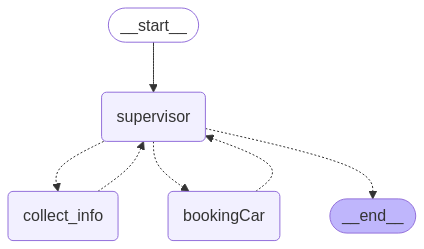

In [ ]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
for s in graph.stream(
    {"messages": [("user", "hi")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'collect_info'}})
----
(('collect_info:55b310c8-445a-2dad-cf66-5357116ace48',), {'agent': {'messages': [AIMessage(content="I'm here to help you with your booking details. Could you please provide your name?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 82, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-a5ec8291-d1ab-48ff-8db5-beabb00e55c3-0', usage_metadata={'input_tokens': 82, 'output_tokens': 18, 'total_tokens': 100, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}})
----
(('collect_info:55b310c8-445a-2dad-cf66-5357116ace48',

KeyboardInterrupt: 